In [8]:
# DO ANY PASSES OVERLAP

In [9]:
# Import necessary libraries
import ephem
import math
from datetime import timedelta


# get_passes() function definition
def new_get_passes(observer, tle, start_time, num_passes=None, duration=None):
    """Config obs and sat, Return pass data for all passes in given interval.

    Arguments:
    observer -- 4 element list containing desired [name,lat,lon,alt]
    tle -- 3 element list containing desired tle [line0,line1,line2]
    start_time -- ephem.date string formatted 'yyyy/mm/dd hr:min:sec'
    num_passes -- integer number of desired passes (defualt None)
    duration -- float number of hours or fraction of hours (default None)

    Specify either num_passes or duration.
    If both, use min(num_passes, duration).
    If neither, find passes for next 24 hours.
    """

    obs_name, obs_lat, obs_lon, obs_alt = observer
    tle_line0, tle_line1, tle_line2 = tle

    # Set up location of observer
    ground_station = ephem.Observer()
    ground_station.name = obs_name                # name string
    ground_station.lon = obs_lon                  # in degrees (+E)
    ground_station.lat = obs_lat                  # in degrees (+N)
    ground_station.elevation = obs_alt            # in meters
    ground_station.date = ephem.date(start_time)  # in UTC

    # Read in most recent satellite TLE data
    sat = ephem.readtle(tle_line0, tle_line1, tle_line2)

    contacts = []

    if duration is None and num_passes is None:
        # get passes for next 24 hrs
        duration = 24
        # set num_passes > max passes possible in duration.
        # duration is in hours, so 4 per hour is large
        # enough for duration to break out of loop.
        num_passes = 4 * int(duration)
        # set end_time longer than suggested length for tle's
        end_time = ephem.date(ground_station.date+5*365)
    if duration is not None and num_passes is None:
        # set num_passes > max passes possible in duration.
        # duration is in hours, so 4 per hour is large
        # enough for duration to break out of loop.
        num_passes = 4 * int(duration)
        end_time = ephem.date(ground_station.date+duration*ephem.hour)
    if duration is None and num_passes is not None:
        # set end_time longer than suggested length for tle's
        end_time = ephem.date(ground_station.date+5*365)
    if num_passes is not None and duration is not None:
        # if both are given, use minimum
        end_time = ephem.date(ground_station.date+duration*ephem.hour)

    try:
        for i in range(num_passes):
            if ground_station.date > end_time:
                break
            sat.compute(ground_station)  # compute all body attributes for sat
            # next pass command yields array with [0]=rise time,
            # [1]=rise azimuth, [2]=max alt time, [3]=max alt,
            # [4]=set time, [5]=set azimuth
            info = ground_station.next_pass(sat)
            rise_time, rise_az, max_alt_time, max_alt, set_time, set_az = info
            deg_per_rad = 180.0/math.pi           # use to conv azimuth to deg
            try:
                pass_duration = timedelta(days=set_time-rise_time)  # timedelta
                r_angle = (rise_az*deg_per_rad)
                s_angle = (set_az*deg_per_rad)
            except TypeError:
                # when no set or rise time
                pass
            try:
                rising = rise_time.datetime().ctime()
                setting = set_time.datetime().ctime()
                pass_seconds = timedelta.total_seconds(pass_duration)
            except AttributeError:
                # when no set or rise time
                pass

            pass_data = {
                'start': rising,
                'end': setting,
                'duration': pass_seconds,
                'rise_az': r_angle,
                'set_az': s_angle,
            }

            try:
                if set_time > rise_time:  # only update if set time > rise time
                    ground_station.date = set_time  # new obs time = prev set time
                    if ground_station.date <= end_time:
                        contacts.append(pass_data)
            except TypeError:
                pass

            # increase by 1 min and look for next pass
            ground_station.date = ground_station.date + ephem.minute
    except ValueError:
        # No (more) visible passes
        pass
    return contacts


In [10]:
from itertools import islice
data = []
with open('amateur.txt') as f:
    while True:
        #an iterator that returns the next N lines and stops
        tripleline = islice(f, 3)
        #loop over these N lines, removing trailing spaces and \n
        tle = [x.rstrip() for x in tripleline]

        #only accept complete data
        #the end of the file *should* have len(tle)==0 but
        #this also handles extra junk at the end
        if len(tle) == 3:
            data.append(tle)
        else:
            break


In [24]:
vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
start_time = '2017/6/8 00:00:00'
num_passes = None
duration = 24.0
vu_passes = {}

for tle in data:
    # use NORAD ID as key for each satellite
    # value is list of passes, where each pass is a dictionary of data
    noradID = tle[2][2:7]
    vu_passes[noradID] = new_get_passes(vu, tle, start_time, num_passes=num_passes, duration=duration)

    

In [12]:
a = [len(data),int(duration)]
a

[74, 24]

In [13]:
for sat, passes in vu_passes.items():
    for obs in passes:
        print('NORAD ID:', sat, 'START:', obs['start'], 'END:', obs['end'])


NORAD ID: 40908 START: Thu Jun  8 00:48:43 2017 END: Thu Jun  8 00:56:19 2017
NORAD ID: 40908 START: Thu Jun  8 10:45:14 2017 END: Thu Jun  8 10:55:08 2017
NORAD ID: 40908 START: Thu Jun  8 12:18:44 2017 END: Thu Jun  8 12:30:45 2017
NORAD ID: 40908 START: Thu Jun  8 13:54:51 2017 END: Thu Jun  8 14:01:17 2017
NORAD ID: 40908 START: Thu Jun  8 21:28:39 2017 END: Thu Jun  8 21:36:44 2017
NORAD ID: 40908 START: Thu Jun  8 23:00:04 2017 END: Thu Jun  8 23:12:19 2017
NORAD ID: 40025 START: Thu Jun  8 03:51:52 2017 END: Thu Jun  8 03:58:44 2017
NORAD ID: 40025 START: Thu Jun  8 05:25:20 2017 END: Thu Jun  8 05:38:28 2017
NORAD ID: 40025 START: Thu Jun  8 07:01:42 2017 END: Thu Jun  8 07:12:42 2017
NORAD ID: 40025 START: Thu Jun  8 14:46:11 2017 END: Thu Jun  8 14:52:26 2017
NORAD ID: 40025 START: Thu Jun  8 16:17:35 2017 END: Thu Jun  8 16:30:17 2017
NORAD ID: 40025 START: Thu Jun  8 17:54:06 2017 END: Thu Jun  8 18:05:38 2017
NORAD ID: 38340 START: Thu Jun  8 00:03:40 2017 END: Thu Jun  8 


NORAD ID: 41783 START: Thu Jun  8 16:48:27 2017 END: Thu Jun  8 17:00:59 2017
NORAD ID: 26931 START: Thu Jun  8 00:40:53 2017 END: Thu Jun  8 00:51:18 2017
NORAD ID: 26931 START: Thu Jun  8 02:29:33 2017 END: Thu Jun  8 02:36:27 2017
NORAD ID: 26931 START: Thu Jun  8 04:13:46 2017 END: Thu Jun  8 04:25:33 2017
NORAD ID: 26931 START: Thu Jun  8 05:56:46 2017 END: Thu Jun  8 06:12:25 2017
NORAD ID: 26931 START: Thu Jun  8 07:40:22 2017 END: Thu Jun  8 07:55:18 2017
NORAD ID: 26931 START: Thu Jun  8 19:02:24 2017 END: Thu Jun  8 19:06:29 2017
NORAD ID: 26931 START: Thu Jun  8 20:38:42 2017 END: Thu Jun  8 20:53:55 2017
NORAD ID: 26931 START: Thu Jun  8 22:21:55 2017 END: Thu Jun  8 22:37:25 2017
NORAD ID: 39770 START: Thu Jun  8 03:33:52 2017 END: Thu Jun  8 03:42:08 2017
NORAD ID: 39770 START: Thu Jun  8 05:06:28 2017 END: Thu Jun  8 05:19:30 2017
NORAD ID: 39770 START: Thu Jun  8 06:43:59 2017 END: Thu Jun  8 06:54:34 2017
NORAD ID: 39770 START: Thu Jun  8 16:52:35 2017 END: Thu Jun  8

Thu Jun  8 11:19:56 2017 END: Thu Jun  8 11:33:55 2017
NORAD ID: 36122 START: Thu Jun  8 13:06:02 2017 END: Thu Jun  8 13:25:54 2017
NORAD ID: 36122 START: Thu Jun  8 14:54:13 2017 END: Thu Jun  8 15:12:11 2017
NORAD ID: 36122 START: Thu Jun  8 16:43:51 2017 END: Thu Jun  8 16:53:04 2017
NORAD ID: 36122 START: Thu Jun  8 21:51:27 2017 END: Thu Jun  8 22:04:52 2017
NORAD ID: 36122 START: Thu Jun  8 23:34:29 2017 END: Thu Jun  8 23:53:50 2017
NORAD ID: 39440 START: Thu Jun  8 00:36:01 2017 END: Thu Jun  8 00:49:18 2017
NORAD ID: 39440 START: Thu Jun  8 02:14:12 2017 END: Thu Jun  8 02:25:07 2017
NORAD ID: 39440 START: Thu Jun  8 12:26:39 2017 END: Thu Jun  8 12:38:42 2017
NORAD ID: 39440 START: Thu Jun  8 14:02:34 2017 END: Thu Jun  8 14:16:45 2017
NORAD ID: 39440 START: Thu Jun  8 15:40:33 2017 END: Thu Jun  8 15:50:01 2017
NORAD ID: 39440 START: Thu Jun  8 23:25:53 2017 END: Thu Jun  8 23:36:30 2017
NORAD ID: 39427 START: Thu Jun  8 01:22:52 2017 END: Thu Jun  8 01:32:19 2017
NORAD ID:

In [14]:
year = 365
start_time = ephem.date('2017/6/8 00:00:00')
access_list = []
day_list = []
for days in range(year):
    vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
    num_passes = None
    duration = 24.0
    vu_passes = {}

    #print(start_time)

    for tle in data:
        # use NORAD ID as key for each satellite
        # value is list of passes, where each pass is a dictionary of data
        noradID = tle[2][2:7]
        vu_passes[noradID] = new_get_passes(vu, tle, start_time, num_passes=num_passes, duration=duration)

    access_time = 0
    for sat, passes in vu_passes.items():
        for obs in passes:
            access_time = access_time + obs['duration']
    access_list.append(access_time)
    day_list.append(days)
    start_time = start_time + 1



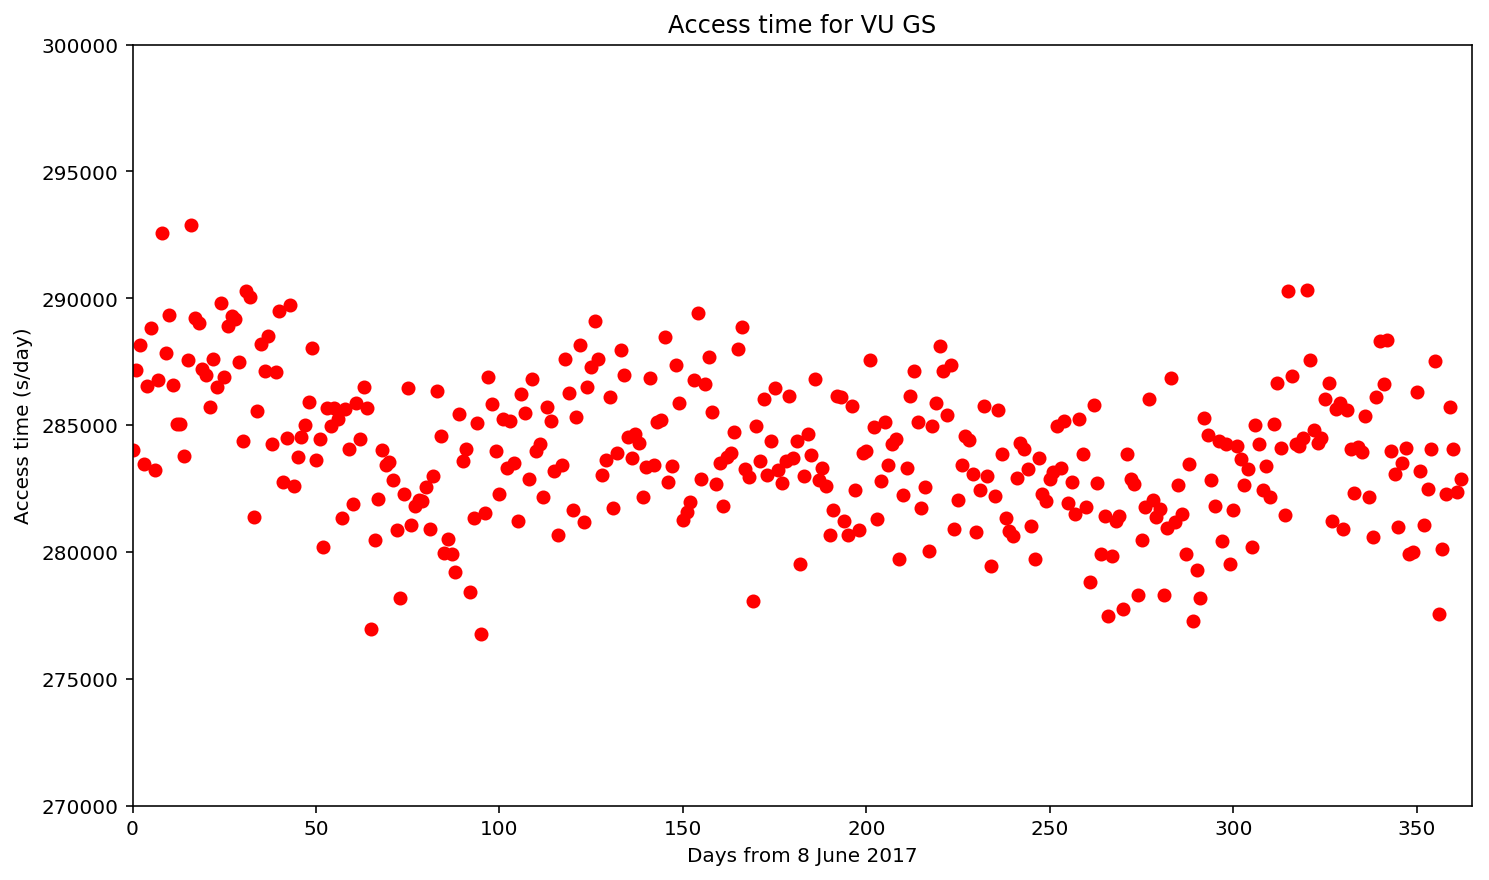

In [15]:
import matplotlib.pyplot as plt


plt.plot(day_list, access_list, 'ro')
plt.title('Access time for VU GS')
plt.xlabel('Days from 8 June 2017')
plt.ylabel('Access time (s/day)')
plt.axis([0,365,270000,300000])
plt.show()

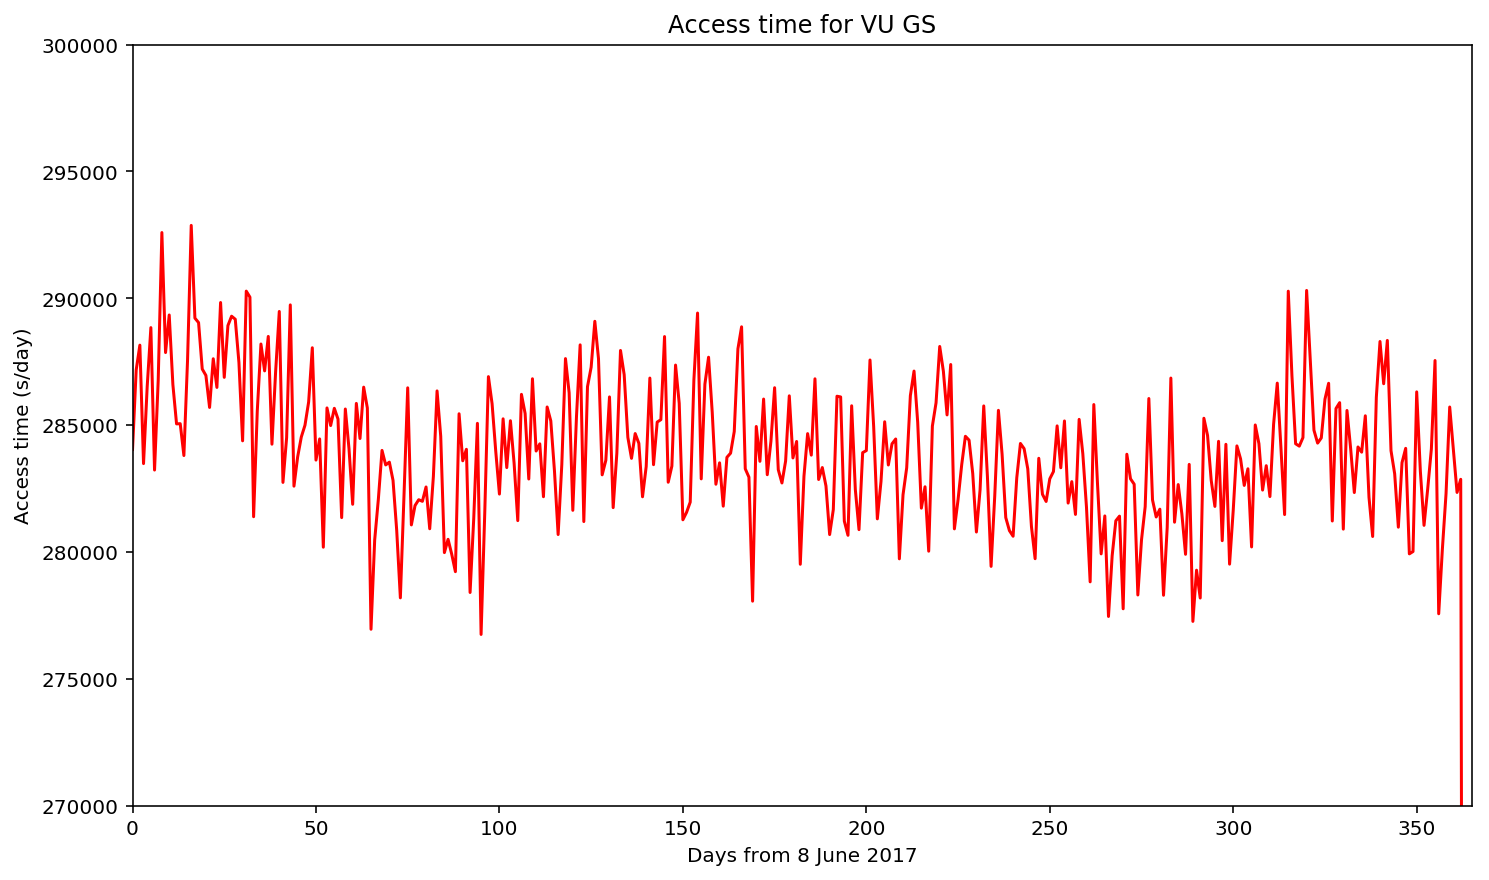

In [16]:
plt.plot(day_list, access_list, 'r-')
plt.title('Access time for VU GS')
plt.xlabel('Days from 8 June 2017')
plt.ylabel('Access time (s/day)')
plt.axis([0,365,270000,300000])
plt.show()

In [17]:
year = 365
start_time = ephem.date('2017/6/8 00:00:00')
access_list = []
day_list = []
for days in range(year):
    vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
    num_passes = None
    duration = 24.0
    vu_passes = {}
    tle = ['ISS (ZARYA)', '1 25544U 98067A   17157.94655197  .00002630  00000-0  47191-4 0  9994', '2 25544  51.6418  89.3693 0004703 241.3496 157.2990 15.53992000 60168']
    noradID = tle[2][2:7]
    vu_passes[noradID] = new_get_passes(vu, tle, start_time, num_passes=num_passes, duration=duration)

    access_time = 0
    for sat, passes in vu_passes.items():
        for obs in passes:
            access_time = access_time + obs['duration']
    access_list.append(access_time)
    day_list.append(days)
    start_time = start_time + 1


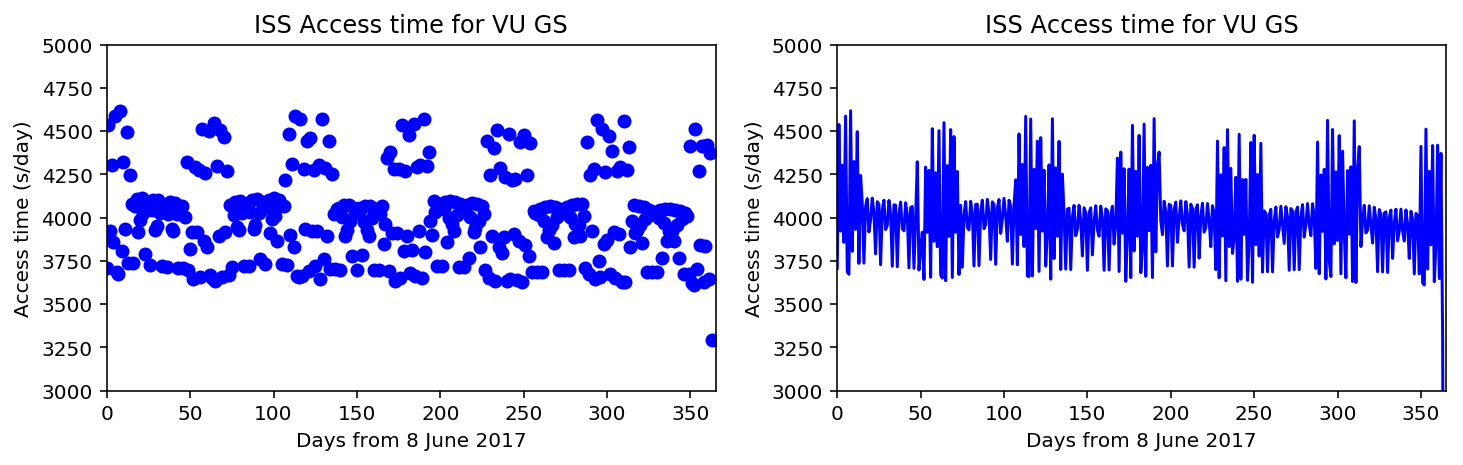

In [18]:
plt.figure(1)

plt.subplot(221)
plt.plot(day_list, access_list, 'bo')
plt.title('ISS Access time for VU GS')
plt.xlabel('Days from 8 June 2017')
plt.ylabel('Access time (s/day)')
plt.axis([0,365,3000,5000])

plt.subplot(222)
plt.plot(day_list, access_list, 'b-')
plt.title('ISS Access time for VU GS')
plt.xlabel('Days from 8 June 2017')
plt.ylabel('Access time (s/day)')
plt.axis([0,365,3000,5000])

plt.show()

In [23]:
class TLE:
    def __init__(self, tle):
        self.tle = tle
        self.tle0 = tle[0]
        self.tle1 = tle[1]
        self.tle2 = tle[2]
        self.name = tle[0].rstrip()
        self.noradid = tle[1][2:7]
        self.epoch = tle[1][18:32]
        self.inclination = tle[2][8:16]

    def __str__(self):
        return '%s\n%s\n%s' % (self.tle0, self.tle1, self.tle2)



In [20]:
def plot_access_time(start, gs, tle):
    """Plots Access Time in seconds/day.

    Arguments:
    start -- string formatted 'yyyy/mm/dd HH:MM:SS'
    gs -- 4 element list containing desired [name,lat,lon,alt]
    tle -- 3 element list containing desired tle [line0,line1,line2]
    """
    year = 365
    start_time = ephem.date(start)
    access_list = []
    day_list = []
    tle = TLE(tle)

    for days in range(year):
        num_passes = None
        duration = 24.0
        gs_passes = {}

        gs_passes[tle.noradid] = new_get_passes(gs, tle.tle, start_time, num_passes=num_passes, duration=duration)

        access_time = 0
        for sat, passes in gs_passes.items():
            for obs in passes:
                access_time = access_time + obs['duration']
        access_list.append(access_time)
        day_list.append(days)
        start_time = start_time + 1

    fig = plt.figure(1)
    fig.suptitle('%s Access time for %s GS' % (tle.name, gs[0]))

    s1 = plt.subplot(221)
    s1.plot(day_list, access_list, 'b.')
    plt.xlabel('Days from %s' % (start))
    plt.ylabel('Access time (sec/day)')

    plt.subplot(222)
    plt.plot(day_list, access_list, 'b-')
    plt.xlabel('Days from %s' % (start))

    plt.show()

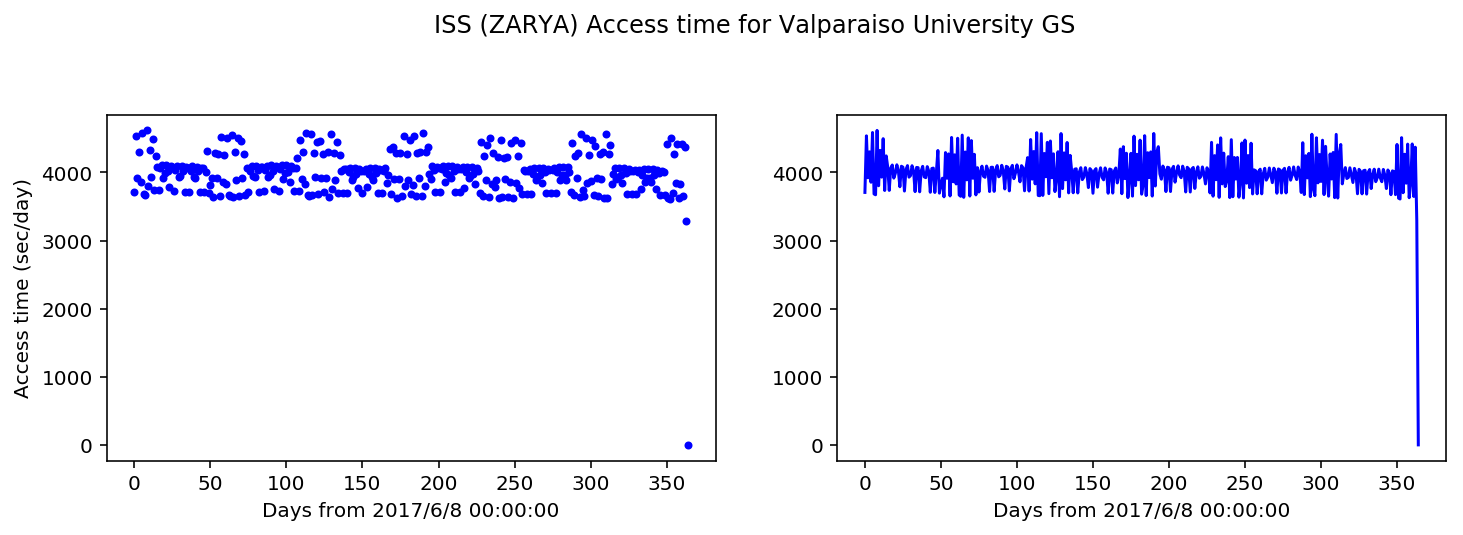

In [21]:
vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
tle = ['ISS (ZARYA)', '1 25544U 98067A   17157.94655197  .00002630  00000-0  47191-4 0  9994', '2 25544  51.6418  89.3693 0004703 241.3496 157.2990 15.53992000 60168']
start = '2017/6/8 00:00:00'

plot_access_time(start, vu, tle)

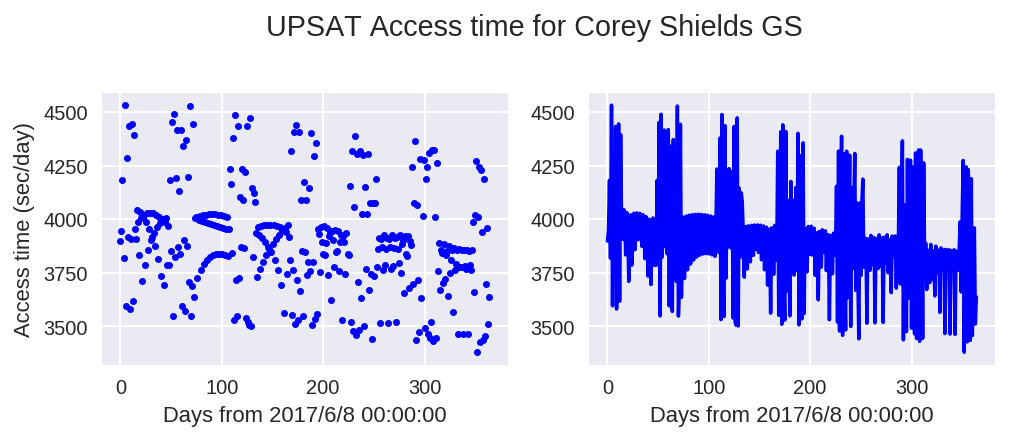

In [22]:
cs = ['Corey Shields', '39.236', '-86.305', 280]
tle = ['UPSAT                   ','1 42716U 98067LX  17166.72694047  .00011068  00000-0  16523-3 0  9996','2 42716  51.6407  45.3505 0004198 326.8454  33.2274 15.55584668  4414']
start = '2017/6/8 00:00:00'

import seaborn
plot_access_time(start, cs, tle)

In [25]:
vu_passes

{'07530': [{'duration': 1010.650778,
   'end': 'Thu Jun  8 07:44:34 2017',
   'rise_az': 36.195549317728734,
   'set_az': 135.92390637027194,
   'start': 'Thu Jun  8 07:27:43 2017'},
  {'duration': 1358.190061,
   'end': 'Thu Jun  8 09:41:42 2017',
   'rise_az': 18.770174339253565,
   'set_az': 190.05842844866226,
   'start': 'Thu Jun  8 09:19:04 2017'},
  {'duration': 1234.451783,
   'end': 'Thu Jun  8 11:32:52 2017',
   'rise_az': 10.051527509965144,
   'set_az': 237.31913010862175,
   'start': 'Thu Jun  8 11:12:18 2017'},
  {'duration': 761.902034,
   'end': 'Thu Jun  8 13:18:54 2017',
   'rise_az': 3.121677342225444,
   'set_az': 291.59949038617015,
   'start': 'Thu Jun  8 13:06:12 2017'},
  {'duration': 587.030825,
   'end': 'Thu Jun  8 16:52:59 2017',
   'rise_az': 53.02774114980851,
   'set_az': 358.85267484113393,
   'start': 'Thu Jun  8 16:43:12 2017'},
  {'duration': 1145.962921,
   'end': 'Thu Jun  8 18:47:04 2017',
   'rise_az': 110.45268295519035,
   'set_az': 351.66447447

In [27]:
import pickle


In [32]:
pickle.dump(vu_passes, open('vu_passes.pkl','wb'))

In [33]:
%ls

amateur.txt                     pyephem-learning.ipynb
get_passes_rewrites.ipynb       request-tle-get-passes.ipynb
get_passes_test_notebook.ipynb  scheduling-questions-I.ipynb
ISS_VU_PassTracker.ipynb        tle-requests-practice.ipynb
pyephem-learning.html           vu_passes.pkl


In [36]:
new_passes = pickle.load(open('vu_passes.pkl', 'rb'))

In [38]:
new_passes.keys()

dict_keys(['39430', '40908', '40958', '38340', '25544', '39446', '37839', '32791', '40928', '39436', '40903', '41338', '14781', '39427', '41339', '32785', '39134', '41460', '42017', '36799', '35933', '41789', '40910', '40900', '40012', '41459', '35932', '27844', '40927', '27939', '28895', '27607', '22825', '27848', '41783', '26931', '39770', '40926', '40911', '33493', '24278', '37855', '39136', '32789', '36122', '39153', '40021', '32953', '25397', '40907', '35935', '37841', '40300', '40901', '39444', '40906', '40025', '41458', '41619', '22826', '39090', '40931', '41557', '23439', '40904', '40905', '40912', '39433', '39440', '33499', '40902', '20442', '07530', '39417'])

In [52]:
from itertools import product

A = [1,2,3,4]
B = [5,6,7,8,9]

for gs, sat in product(A,B):
    passes[(gs,sat)] = get_passes(gs, sat, duration)

1 5
1 6
1 7
1 8
1 9
2 5
2 6
2 7
2 8
2 9
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9


In [45]:
p = product(A,B)
type(p)

itertools.product

In [49]:
g = iter(p)

In [48]:
for i in g:
    print(i)

(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
